In [153]:
import pandas as pd
import os
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
palette = ['tab:blue', 'tab:green', 'tab:red']
hue_order = ['PMC', 'SZ', 'SWING']
sns.set(rc={"figure.figsize":(6, 4)})


compressed_dirname = join('..', 'data', 'compressed')


In [144]:
def get_segments_modelardb(compression_name):
    filenames = os.listdir(join(compressed_dirname, compression_name))
    for filename in filenames:
        if 'segments' in filename and 'metadata' in filename and 'test' not in filename:
            print(filename)
            gid_eps_map = {}
            metadata = open(join(compressed_dirname, compression_name, filename))
            for i in range(5): metadata.readline()
            for mapping_text in metadata:
                split_text = mapping_text.split(' ')
                gid_eps_map[int(split_text[0])] = split_text[1].strip()

            parquet_filename = filename.replace('_metadata.txt', '.parquet')
            df = pd.read_parquet(join(compressed_dirname, compression_name, parquet_filename))
            grouped_df = df.groupby('gid').count()
            if 'solar' in filename:
                grouped_df['real_gid'] = (grouped_df.index-1)%13
                grouped_df = grouped_df.groupby('real_gid').mean()
                grouped_df.index += 1

            results = dict()
            for key, row in grouped_df.iterrows():
                if key in gid_eps_map:
                    results[gid_eps_map[key]] = grouped_df.at[key, 'mtid']

            df = pd.DataFrame(list(results.items()), columns=['Index', 'Value']).set_index('Index').sort_index()
            df.to_csv(join('..', 'results', 'segments', compression_name, filename.replace('_metadata.txt', '_count.csv')))


get_segments_modelardb('pmc')
get_segments_modelardb('swing')

aus_electrical_demand_segments_metadata.txt
BELHLE02_output_segments_metadata.txt
ettm1_output_segments_metadata.txt
ettm2_output_segments_metadata.txt
solar_output_segments_metadata.txt
weather_output_segments_metadata.txt
aus_electrical_demand_segments_metadata.txt
BELHLE02_output_segments_metadata.txt
ettm1_output_segments_metadata.txt
ettm2_output_segments_metadata.txt
solar_output_segments_metadata.txt
weather_output_segments_metadata.txt


In [145]:
def get_segments_sz():
    filenames = os.listdir(join(compressed_dirname, 'sz'))
    for filename in filenames:
        print(filename)
        df = pd.read_parquet(join(compressed_dirname, 'sz', filename))
        results = dict()
        for column in df.columns:
            if '-R' in column or 'dat' in column:
                continue

            print(column)
            num_segments = 1
            current_element = df.at[0, column]
            for i in range(1, df.shape[0]):
                if current_element != df.at[i, column]:
                    num_segments += 1
                    current_element = df.at[i, column]

            results[column] = num_segments

        rdf = pd.DataFrame(list(results.items()), columns=['Index', 'Value']).set_index('Index').sort_index()
        rdf.to_csv(join('..', 'results', 'segments', 'sz', filename.replace('data__points.parquet', '_segments_count.csv')))

get_segments_sz()

aus_electrical_demand_points.parquet
y-E0.001
y-E0.003
y-E0.005
y-E0.007
y-E0.01
y-E0.03
y-E0.05
y-E0.07
y-E0.1


KeyboardInterrupt: 

In [202]:
def print_segments(data_name):
    sns.set(rc={"figure.figsize":(6, 4)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    pmc = pd.read_csv(join('..', 'results', 'segments', 'pmc', data_name))
    swing = pd.read_csv(join('..', 'results', 'segments', 'swing', data_name))
    sz = pd.read_csv(join('..', 'results', 'segments', 'sz', data_name))

    error_bounds = list()
    for element in pmc.Index:
        var, e = element.split('E')
        error_bounds.append(float(e)*0.01)

    pmc['error_bounds'] = error_bounds
    pmc = pmc.set_index('error_bounds')
    pmc = pmc.sort_index()
    pmc['eblc'] = 'PMC'
    error_bounds = list()
    for element in swing.Index:
        var, e = element.split('E')
        error_bounds.append(float(e)*0.01)

    swing['error_bounds'] = error_bounds
    swing = swing.set_index('error_bounds')
    swing = swing.sort_index()
    swing['eblc'] = 'SWING'

    error_bounds = list()
    for element in sz.Index:
        var, e = element.split('E')
        error_bounds.append(float(e))

    sz['error_bounds'] = error_bounds

    if 'solar' in data_name:
        sz = sz.groupby('error_bounds').mean()
    else:
        sz = sz.set_index('error_bounds')

    sz = sz.sort_index()
    sz['eblc'] = 'SZ'

    all_results = pd.concat([pmc, swing, sz]).reset_index()
    # display(all_results)
    fig, ax = plt.subplots()

    ax = sns.lineplot(data=all_results,
                      x='error_bounds',
                      y='Value',
                      hue='eblc',
                      palette=palette,
                      hue_order=hue_order
                      )

    plt.legend(title='', fontsize='18', loc='upper right')
    ax.set(ylabel='Number of Segments', xlabel='error bound')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)


    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.ticklabel_format(axis='y', style='scientific')

    ax.set_xlim(0.0, 0.8)
    plt.tight_layout()
    plt.savefig(f"../figures/segments_{data_name.replace('_segments_count.csv', '.pdf')}")
    plt.show()

    # pmc.Value.plot(label='pmc')
    # swing.Value.plot(label='swing')
    # sz.Value.plot(label='sz')
    # plt.legend()
    # plt.show()




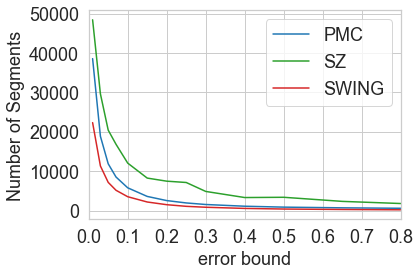

In [203]:
print_segments('ettm1_output_segments_count.csv')

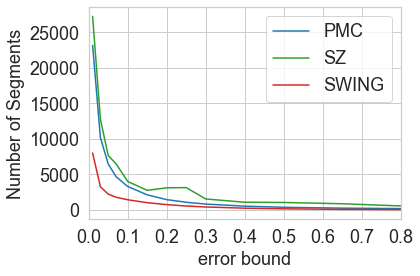

In [200]:
print_segments('ettm2_output_segments_count.csv')

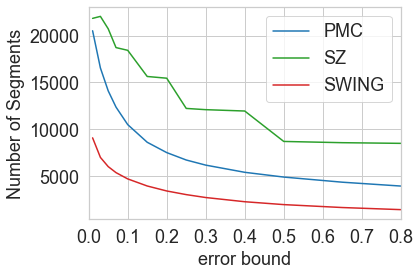

In [182]:
print_segments('solar_output_segments_count.csv')

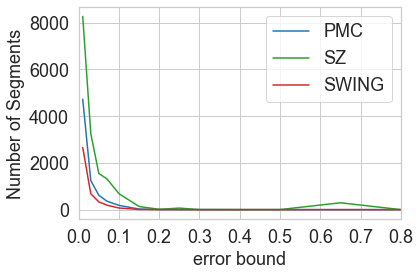

In [183]:
print_segments('weather_output_segments_count.csv')

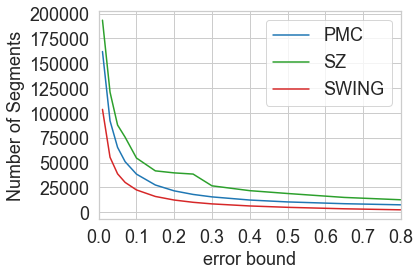

In [184]:
print_segments('wind_output_segments_count.csv')

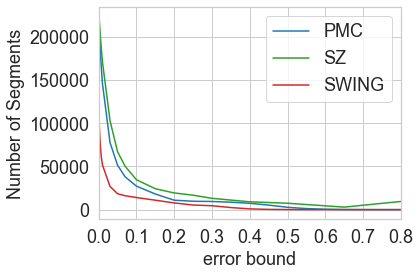

In [176]:
print_segments('aus_electrical_demand_segments_count.csv')